In [1]:
# BiLSTM-based Intrusion Detection on TON IoT Dataset (Rewritten)

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from collections import Counter
from sklearn.model_selection import StratifiedKFold, train_test_split

# Load Dataset
df = pd.read_csv('../dataset/final_df.csv', low_memory=False)
print("Original DataFrame Head:\n", df.head())
print("\nOriginal Class Distribution:\n", df['type'].value_counts())
print("\nOriginal Label Distribution:\n", df['label'].value_counts())
print("\nOriginal Data Types:\n", df.dtypes)
print("\nOriginal Data Shapes:\n", df.shape)

# --- Data Preprocessing ---
# Clean and impute
df['src_bytes'] = pd.to_numeric(df['src_bytes'], errors='coerce').fillna(0)
df.drop_duplicates(inplace=True)

df.fillna(df.mean(numeric_only=True), inplace=True)
print(f"Shape after dropping duplicates: {df.shape}")

for col in df.columns:
    if df[col].isnull().any():
        if df[col].dtype == 'object':
            df[col].fillna('Missing', inplace=True) # Or df[col].mode()[0]
        else:
            df[col].fillna(df[col].mean(), inplace=True)

print(f"Shape after handling NaNs: {df.shape}")

# Identify targets
TARGET_LABEL = 'label'
TARGET_TYPE = 'type'

# Encode categorical columns
categorical_cols = df.select_dtypes(include='object').columns.tolist()
if TARGET_TYPE in categorical_cols:
    categorical_cols.remove(TARGET_TYPE)

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le
    print(f"Encoded column: {col}")

# Normalize numerical features
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
if TARGET_LABEL in numerical_cols:
    numerical_cols.remove(TARGET_LABEL)

print(f"\nCategorical columns: {categorical_cols}")
print(f"Numerical columns: {numerical_cols}")


2025-09-04 20:07:26.653976: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-04 20:07:27.075941: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-04 20:07:28.495888: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Original DataFrame Head:
            ts         src_ip  src_port        dst_ip  dst_port proto service  \
0  1556499101  192.168.1.193     60396  192.168.1.33      8080   tcp       -   
1  1556494424  192.168.1.193     59273  192.168.1.33      8080   tcp       -   
2  1556487945  192.168.1.193     57717  192.168.1.33      8080   tcp       -   
3  1556508616  192.168.1.193     62682  192.168.1.33        80   tcp       -   
4  1556511697  192.168.1.193     63419  192.168.1.33      8080   tcp       -   

   duration src_bytes  dst_bytes  ... http_response_body_len  \
0  0.000180         0          0  ...                      0   
1  0.000111         0          0  ...                      0   
2  0.000148         0          0  ...                      0   
3  0.000127         0          0  ...                      0   
4  0.000122         0          0  ...                      0   

   http_status_code  http_user_agent  http_orig_mime_types  \
0                 0                -          

In [2]:
# binary_y = df[TARGET_LABEL].values
type_encoder = LabelEncoder()
y_multiclass_encoded = type_encoder.fit_transform(df[TARGET_TYPE])
num_classes = len(le.classes_)
# Convert to one-hot encoding for Keras if using categorical_crossentropy
y_multiclass_onehot = to_categorical(y_multiclass_encoded)

y_multiclass_labels = np.argmax(y_multiclass_onehot, axis=1)

# Drop targets from features
X = df.drop(columns=[TARGET_LABEL, TARGET_TYPE]).values
print("Feature shape (flat):", X.shape)
# print("Binary target shape:", binary_y.shape)
print("Multi-class target shape:", y_multiclass_labels.shape)

# print the class distribution of binary_y and y_multiclass_labels
# print("Binary target class distribution:")
# print(Counter(binary_y))
print("Multi-class target class distribution:")
print(Counter(y_multiclass_labels))

Feature shape (flat): (441043, 44)
Multi-class target shape: (441043,)
Multi-class target class distribution:
Counter({np.int64(5): 300000, np.int64(0): 20000, np.int64(1): 20000, np.int64(2): 20000, np.int64(3): 20000, np.int64(6): 20000, np.int64(7): 20000, np.int64(8): 20000, np.int64(4): 1043})


In [3]:
# 1. Split BEFORE SMOTE (to avoid leakage)
# ----------------------------------------
X_train, X_test, y_train_multi, y_test_multi = train_test_split(
    X,
    y_multiclass_onehot,
    test_size=0.2,
    random_state=42,
    stratify=y_multiclass_encoded  # stratify on binary for this example
)

# Reset indices
X_train = pd.DataFrame(X_train).reset_index(drop=True).values
X_test = pd.DataFrame(X_test).reset_index(drop=True).values

print(f"\nX_train shape: {X_train.shape}")
print(f"y_train_multiclass labels shape: {y_train_multi.shape}")
print(f"X_test  shape: {X_test.shape}")
print(f"y_test_multiclass labels shape: {y_test_multi.shape}")

# print the class distribution of binary_y and y_multiclass
# print the class distribution of binary_y and y_multiclass
print("Multi-class target class distribution (train):")
print(Counter(np.argmax(y_train_multi, axis=1)))
print("Multi-class target class distribution (test):")
print(Counter(np.argmax(y_test_multi, axis=1)))

# scaling the training data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("Scaling complete.")


X_train shape: (352834, 44)
y_train_multiclass labels shape: (352834, 9)
X_test  shape: (88209, 44)
y_test_multiclass labels shape: (88209, 9)
Multi-class target class distribution (train):
Counter({np.int64(5): 240000, np.int64(0): 16000, np.int64(6): 16000, np.int64(7): 16000, np.int64(8): 16000, np.int64(2): 16000, np.int64(1): 16000, np.int64(3): 16000, np.int64(4): 834})
Multi-class target class distribution (test):
Counter({np.int64(5): 60000, np.int64(1): 4000, np.int64(3): 4000, np.int64(6): 4000, np.int64(0): 4000, np.int64(8): 4000, np.int64(7): 4000, np.int64(2): 4000, np.int64(4): 209})
Scaling complete.


In [4]:
# --- Create Sequences ---
def create_sequences(
    X,
    y,
    window_size: int = 10,
    debug: bool = False,
    trace_limit: int = 5
):
    # Convert to numpy if not already
    X = np.asarray(X)
    y = np.asarray(y)

    # Input validation
    if len(X) != len(y):
        raise ValueError("X and y must have the same number of samples")
    if len(X.shape) != 2:
        raise ValueError("X must be a 2D array: (samples, features)")
    if len(y.shape) > 2:
        raise ValueError("y must be a 1D or 2D array")

    X_seq, y_seq = [], []
    total = len(X) - window_size + 1
    if debug:
        print(f"Total samples: {len(X)} | Generating {total} sequences (window_size={window_size})")

    for i in range(total):
        window = X[i : i + window_size]
        label = y[i + window_size - 1]
        X_seq.append(window)
        y_seq.append(label)

        if debug and i < trace_limit:
            print(f"\n--- Seq {i+1}/{total} ---")
            print(f"  X indices: {i} to {i+window_size-1}")
            print(f"  y index:   {i+window_size-1} → label={label}")
            print(f"  window.shape: {window.shape}")

    if debug:
        print(f"\nTotal sequences generated: {len(X_seq)}")

    return np.array(X_seq), np.array(y_seq)


TIMESTEPS = 20
X_train_seq, y_train_seq = create_sequences(X_train, y_train_multi, window_size=TIMESTEPS, debug=True)
X_test_seq, y_test_seq = create_sequences(X_test, y_test_multi, window_size=TIMESTEPS, debug=True)


print("Train sequence shape:", X_train_seq.shape)  # (samples, timesteps, features)
print("Test sequence shape:", X_test_seq.shape)
print("multi target distribution:", Counter(np.argmax(y_train_multi, axis=1)))

# counters
print("Class distribution in y_train_seq:", Counter(np.argmax(y_train_seq, axis=1)))
print("Class distribution in y_test_seq:", Counter(np.argmax(y_test_seq, axis=1)))

# multiclass sequence generation.
# X_train_seq_multi, y_train_seq_multi = create_sequences(X_train, y_train_multi, debug=True)
# X_test_seq_multi, y_test_seq_multi = create_sequences(X_test, y_test_multi, debug=True)


Total samples: 352834 | Generating 352815 sequences (window_size=20)

--- Seq 1/352815 ---
  X indices: 0 to 19
  y index:   19 → label=[0. 0. 1. 0. 0. 0. 0. 0. 0.]
  window.shape: (20, 44)

--- Seq 2/352815 ---
  X indices: 1 to 20
  y index:   20 → label=[0. 0. 0. 0. 0. 1. 0. 0. 0.]
  window.shape: (20, 44)

--- Seq 3/352815 ---
  X indices: 2 to 21
  y index:   21 → label=[0. 0. 0. 0. 0. 1. 0. 0. 0.]
  window.shape: (20, 44)

--- Seq 4/352815 ---
  X indices: 3 to 22
  y index:   22 → label=[0. 0. 0. 0. 0. 1. 0. 0. 0.]
  window.shape: (20, 44)

--- Seq 5/352815 ---
  X indices: 4 to 23
  y index:   23 → label=[0. 0. 0. 0. 0. 1. 0. 0. 0.]
  window.shape: (20, 44)

Total sequences generated: 352815
Total samples: 88209 | Generating 88190 sequences (window_size=20)

--- Seq 1/88190 ---
  X indices: 0 to 19
  y index:   19 → label=[0. 0. 0. 0. 0. 1. 0. 0. 0.]
  window.shape: (20, 44)

--- Seq 2/88190 ---
  X indices: 1 to 20
  y index:   20 → label=[0. 0. 0. 0. 0. 1. 0. 0. 0.]
  window.

In [5]:
from sklearn.utils import shuffle

# X_train_seq_bal_shuffle, y_train_seq_bal_shuffle = shuffle(X_train_seq_bal, y_train_seq_bal, random_state=42)
X_train_seq_bal_shuffle, y_train_seq_bal_shuffle = shuffle(X_train_seq, y_train_seq, random_state=42)

val_fraction = 0.2
n_total = X_train_seq_bal_shuffle.shape[0]
n_val = int(n_total * val_fraction)

X_val_seq = X_train_seq_bal_shuffle[-n_val:]
y_val_seq = y_train_seq_bal_shuffle[-n_val:]
X_train_seq_final = X_train_seq_bal_shuffle[:-n_val]
y_train_seq_final = y_train_seq_bal_shuffle[:-n_val]

print("Final training shapes:")
print(f"X_train_seq_final shape: {X_train_seq_final.shape}")
print(f"y_train_seq_final shape: {y_train_seq_final.shape}")
print(f"X_val_seq shape: {X_val_seq.shape}")
print(f"y_val_seq shape: {y_val_seq.shape}")

print("Final training label distributions:")
print(f"y_train_seq_final distribution: {Counter(np.argmax(y_train_seq_final, axis=1))}")
print(f"y_val_seq distribution: {Counter(np.argmax(y_val_seq, axis=1))}")

Final training shapes:
X_train_seq_final shape: (282252, 20, 44)
y_train_seq_final shape: (282252, 9)
X_val_seq shape: (70563, 20, 44)
y_val_seq shape: (70563, 9)
Final training label distributions:
y_train_seq_final distribution: Counter({np.int64(5): 192120, np.int64(7): 12859, np.int64(2): 12851, np.int64(3): 12828, np.int64(6): 12792, np.int64(8): 12747, np.int64(0): 12710, np.int64(1): 12690, np.int64(4): 655})
y_val_seq distribution: Counter({np.int64(5): 47868, np.int64(1): 3310, np.int64(0): 3289, np.int64(8): 3252, np.int64(6): 3207, np.int64(3): 3172, np.int64(2): 3149, np.int64(7): 3138, np.int64(4): 178})


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.metrics import Precision
from tensorflow.keras.layers import LayerNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, AUC
from sklearn.metrics import (confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, matthews_corrcoef, roc_auc_score, classification_report, roc_curve, precision_recall_curve)
import matplotlib.pyplot as plt

# Model definition
model = Sequential([
    Bidirectional(LSTM(
        128, 
        return_sequences=True,  # Only final output
        recurrent_dropout=0.2,
        recurrent_activation='sigmoid',
        activation='tanh'
    ),
    input_shape=(X_train_seq_final.shape[1], X_train_seq_final.shape[2])),
    LayerNormalization(),
    Dropout(0.2),
    Bidirectional(LSTM(64)),
    LayerNormalization(),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(9, activation='softmax')
])
model.summary()

optimizer = Adam(
    learning_rate=0.0001,  # Very low initial LR
    clipnorm=1.0,  # Gradient clipping to prevent exploding gradients
    weight_decay=1e-4
)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        AUC(name='auc'),
        Recall(name='recall'),
        Precision(name='precision')
    ]
)

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.arange(y_multiclass_onehot.shape[1]),
    y=y_multiclass_onehot.argmax(axis=1)
)
class_weight_dict = dict(enumerate(class_weights))
# 🚀 Boost class 4 priority (e.g., 2x higher than balanced weight)
# class_weight_dict[4] *= 3.0
# multipliers = [1.0, 1.5, 1.0, 0.9, 3.0, 0.6, 0.9, 1.0, 2.0]
multipliers = [1.0, 1.2, 1.0, 1.0, 2.0, 0.7, 1.0, 1.0, 1.2]


for k, m in enumerate(multipliers):
    class_weight_dict[k] *= m

print(class_weight_dict)

# Train
history = model.fit(
    X_train_seq_final, y_train_seq_final,
    validation_data=(X_val_seq, y_val_seq),
    epochs=15,
    batch_size=64,
    shuffle=False,  # Important for time series
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weight_dict,
    verbose=1
)

results = model.evaluate(X_test_seq, y_test_seq, verbose=2)

print("Test Loss: {}".format(results[0]))
print("Test Accuracy: {}".format(results[1]))


I0000 00:00:1756996927.072858    7150 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2278 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2050, pci bus id: 0000:01:00.0, compute capability: 8.6
/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 20, 256)        │       177,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization             │ (None, 20, 256)        │           512 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_1           │ (None, 128)            │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 351,113 (1.34 MB)

 Trainable params: 351,113 (1.34 MB)

 Non-trainable params: 0 (0.00 B)

{0: np.float64(2.450238888888889), 1: np.float64(3.6753583333333335), 2: np.float64(2.450238888888889), 3: np.float64(2.205215), 4: np.float64(140.9533397251518), 5: np.float64(0.09800955555555554), 6: np.float64(2.205215), 7: np.float64(2.450238888888889), 8: np.float64(4.900477777777778)}
Epoch 1/10


2025-09-04 20:27:15.919521: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91200


4411/4411 ━━━━━━━━━━━━━━━━━━━━ 170s 37ms/step - accuracy: 0.4630 - auc: 0.8603 - loss: 2.0126 - precision: 0.6495 - recall: 0.3696 - val_accuracy: 0.6921 - val_auc: 0.9419 - val_loss: 0.9505 - val_precision: 0.7768 - val_recall: 0.6343 - learning_rate: 1.0000e-04
Epoch 2/10
4411/4411 ━━━━━━━━━━━━━━━━━━━━ 164s 37ms/step - accuracy: 0.7385 - auc: 0.9535 - loss: 1.0651 - precision: 0.7850 - recall: 0.7017 - val_accuracy: 0.7989 - val_auc: 0.9682 - val_loss: 0.6634 - val_precision: 0.8311 - val_recall: 0.7806 - learning_rate: 1.0000e-04
Epoch 3/10
4411/4411 ━━━━━━━━━━━━━━━━━━━━ 164s 37ms/step - accuracy: 0.8192 - auc: 0.9748 - loss: 0.6617 - precision: 0.8447 - recall: 0.7986 - val_accuracy: 0.8711 - val_auc: 0.9826 - val_loss: 0.4566 - val_precision: 0.8929 - val_recall: 0.8524 - learning_rate: 1.0000e-04
Epoch 4/10
4411/4411 ━━━━━━━━━━━━━━━━━━━━ 165s 37ms/step - accuracy: 0.8599 - auc: 0.9830 - loss: 0.5024 - precision: 0.8765 - recall: 0.8466 - val_accuracy: 0.8897 - val_auc: 0.9864 - v

2756/2756 ━━━━━━━━━━━━━━━━━━━━ 27s 10ms/step
              precision    recall  f1-score   support

           0       0.74      1.00      0.85      3997
           1       0.88      0.97      0.92      3998
           2       0.84      0.97      0.90      4000
           3       0.90      0.97      0.93      3999
           4       0.17      0.96      0.29       209
           5       1.00      0.92      0.96     59991
           6       0.90      1.00      0.95      3998
           7       0.93      0.99      0.96      3999
           8       0.89      0.94      0.92      3999

    accuracy                           0.94     88190
   macro avg       0.81      0.97      0.85     88190
weighted avg       0.95      0.94      0.94     88190

[[ 3997     0     0     0     0     0     0     0     0]
 [    0  3862     3   106     0     7    11     6     3]
 [    0     0  3866    15     0   119     0     0     0]
 [    0    54    68  3872     0     2     0     1     2]
 [    0     0     0   

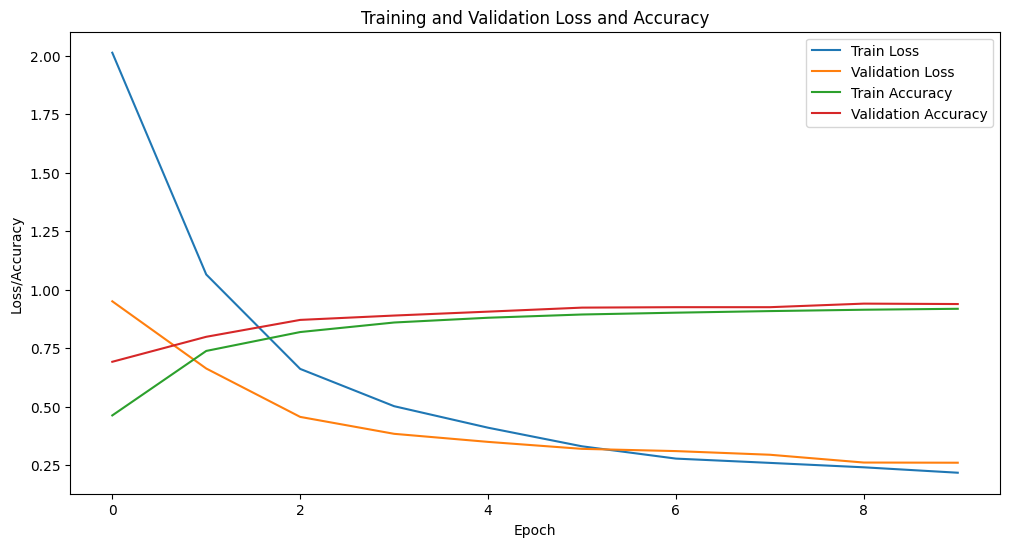

In [ ]:

# Print classification report
y_pred_probs = model.predict(X_test_seq)
y_pred_classes = y_pred_probs.argmax(axis=1)
y_true_classes = y_test_seq.argmax(axis=1)
print(classification_report(y_true_classes, y_pred_classes))

#confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
print(cm)

# For multi-class, FNR and FPR are not simply tn, fp, fn, tp.
# If you want per-class FNR/FPR:
fnr = []
fpr = []
for i in range(cm.shape[0]):
    fn = cm[i, :].sum() - cm[i, i]
    tp = cm[i, i]
    fp = cm[:, i].sum() - cm[i, i]
    tn = cm.sum() - (tp + fn + fp)
    fnr.append(fn / (fn + tp) if (fn + tp) > 0 else 0)
    fpr.append(fp / (fp + tn) if (fp + tn) > 0 else 0)
print("False Negative Rate (FNR) per class:", fnr)
print("False Positive Rate (FPR) per class:", fpr)

results_df = pd.DataFrame({
    "Class": type_encoder.classes_,
    "FNR": fnr,
    "FPR": fpr
})

print(results_df.to_string(index=False))

# plot validation loss and accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Loss and Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()


/home/jinesh-subedi/htdocs/thesis/thesisStudy/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_2 (Bidirectional) │ (None, 20, 256)        │       177,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_2           │ (None, 20, 256)        │           512 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 20, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_3           │ (None, 128)            │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 351,113 (1.34 MB)

 Trainable params: 351,113 (1.34 MB)

 Non-trainable params: 0 (0.00 B)

{0: np.float64(2.450238888888889), 1: np.float64(2.9402866666666667), 2: np.float64(2.450238888888889), 3: np.float64(2.450238888888889), 4: np.float64(93.96889315010121), 5: np.float64(0.11434448148148146), 6: np.float64(2.450238888888889), 7: np.float64(2.450238888888889), 8: np.float64(2.9402866666666667)}
Epoch 1/15
4411/4411 ━━━━━━━━━━━━━━━━━━━━ 171s 38ms/step - accuracy: 0.5283 - auc: 0.8919 - loss: 1.6342 - precision: 0.7096 - recall: 0.4255 - val_accuracy: 0.6881 - val_auc: 0.9506 - val_loss: 0.8658 - val_precision: 0.7410 - val_recall: 0.6043 - learning_rate: 2.0000e-04
Epoch 2/15
4411/4411 ━━━━━━━━━━━━━━━━━━━━ 166s 38ms/step - accuracy: 0.7851 - auc: 0.9684 - loss: 0.8817 - precision: 0.8273 - recall: 0.7495 - val_accuracy: 0.8807 - val_auc: 0.9795 - val_loss: 0.5123 - val_precision: 0.8949 - val_recall: 0.8612 - learning_rate: 2.0000e-04
Epoch 3/15
4411/4411 ━━━━━━━━━━━━━━━━━━━━ 166s 38ms/step - accuracy: 0.8542 - auc: 0.9817 - loss: 0.5269 - precision: 0.8729 - recall: 0.83

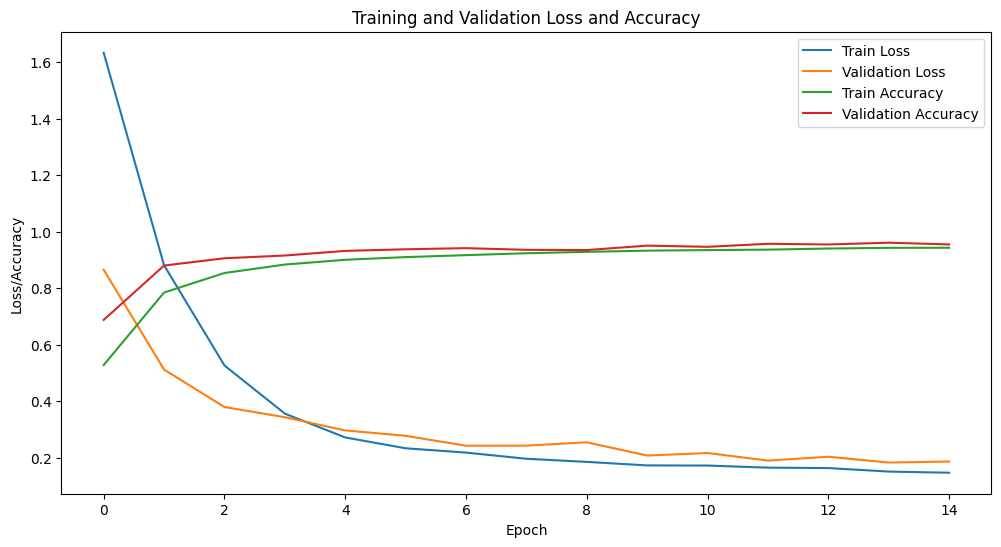

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.metrics import Precision
from tensorflow.keras.layers import LayerNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, AUC
from sklearn.metrics import (confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, matthews_corrcoef, roc_auc_score, classification_report, roc_curve, precision_recall_curve)
import matplotlib.pyplot as plt

# Model definition
model = Sequential([
    Bidirectional(LSTM(
        128, 
        return_sequences=True,  # Only final output
        recurrent_dropout=0.2,
        recurrent_activation='sigmoid',
        activation='tanh'
    ),
    input_shape=(X_train_seq_final.shape[1], X_train_seq_final.shape[2])),
    LayerNormalization(),
    Dropout(0.3),
    Bidirectional(LSTM(64)),
    LayerNormalization(),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dense(9, activation='softmax')
])
model.summary()

optimizer = Adam(
    learning_rate=0.0002,  # Very low initial LR
    clipnorm=1.0,  # Gradient clipping to prevent exploding gradients
    weight_decay=1e-4
)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        AUC(name='auc'),
        Recall(name='recall'),
        Precision(name='precision')
    ]
)

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.arange(y_multiclass_onehot.shape[1]),
    y=y_multiclass_onehot.argmax(axis=1)
)
class_weight_dict = dict(enumerate(class_weights))
# 🚀 Boost class 4 priority (e.g., 2x higher than balanced weight)
# class_weight_dict[4] *= 3.0
# multipliers = [1.0, 1.5, 1.0, 0.9, 3.0, 0.6, 0.9, 1.0, 2.0]
multipliers = [1.0, 1.2, 1.0, 1.0, 2.0, 0.7, 1.0, 1.0, 1.2]


for k, m in enumerate(multipliers):
    class_weight_dict[k] *= m

print(class_weight_dict)

# Train
history = model.fit(
    X_train_seq_final, y_train_seq_final,
    validation_data=(X_val_seq, y_val_seq),
    epochs=15,
    batch_size=64,
    shuffle=False,  # Important for time series
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weight_dict,
    verbose=1
)

results = model.evaluate(X_test_seq, y_test_seq, verbose=2)

print("Test Loss: {}".format(results[0]))
print("Test Accuracy: {}".format(results[1]))


# Print classification report
y_pred_probs = model.predict(X_test_seq)
y_pred_classes = y_pred_probs.argmax(axis=1)
y_true_classes = y_test_seq.argmax(axis=1)
print(classification_report(y_true_classes, y_pred_classes))

#confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
print(cm)

# For multi-class, FNR and FPR are not simply tn, fp, fn, tp.
# If you want per-class FNR/FPR:
fnr = []
fpr = []
for i in range(cm.shape[0]):
    fn = cm[i, :].sum() - cm[i, i]
    tp = cm[i, i]
    fp = cm[:, i].sum() - cm[i, i]
    tn = cm.sum() - (tp + fn + fp)
    fnr.append(fn / (fn + tp) if (fn + tp) > 0 else 0)
    fpr.append(fp / (fp + tn) if (fp + tn) > 0 else 0)
print("False Negative Rate (FNR) per class:", fnr)
print("False Positive Rate (FPR) per class:", fpr)

results_df = pd.DataFrame({
    "Class": type_encoder.classes_,
    "FNR": fnr,
    "FPR": fpr
})

print(results_df.to_string(index=False))

# plot validation loss and accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Loss and Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()

